# LightGBM

* Install: https://towardsdatascience.com/install-xgboost-and-lightgbm-on-apple-m1-macs-cb75180a2dda

### Load libraries

In [2]:
import sys
sys.path.append("../../")
import ltr.judgments as judge
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style, rc, font_manager
%matplotlib inline
style.use('ggplot')
plt.rcParams['figure.figsize'] = (50,150)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True 
# font 설정
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import lightgbm as lgb

def read_ranking_data(data_path):
    df = [j for j in judge.judgments_from_file(open(data_path))]
    return judge.judgments_to_dataframe(df)

### Define service and data

In [3]:
SERVICE = "card"
PERIOD = "1w"
DATA_CREATED_AT = "20220429"
RANKING_DATA = f"{DATA_CREATED_AT}.{SERVICE}.click.ranking.base.{PERIOD}.features.grade.txt"
RANKING_DATA_PATH = f"../../rdataset/{SERVICE}/{RANKING_DATA}"
FEATURE_MAP_PATH = RANKING_DATA_PATH.replace(".txt", ".fmap.txt")
print(f"SERVICE: {SERVICE}\nPERIOD: {PERIOD}\nDATA_CREATED_AT: {DATA_CREATED_AT}")
print(RANKING_DATA_PATH)

SERVICE: card
PERIOD: 1w
DATA_CREATED_AT: 20220429
../../rdataset/card/20220429.card.click.ranking.base.1w.features.grade.txt


### Read ranking data and featuremap

In [4]:
rdf = read_ranking_data(RANKING_DATA_PATH)
rdf

Recognizing 2773 queries in: ../../rdataset/card/20220429.card.click.ranking.base.1w.features.grade.txt


../../ltr/judgments.py:286: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



,features0,features1,features2,features3,features4,features5,features6,features7,features8,features9,...,features29,features30,features31,features32,features33,uid,qid,keywords,docId,grade
0,0.242670,0.139326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030766,...,4.317488,0.0,0.183579,0.0,0.0,1_15427840,1,#거실인테리어,15427840,0
1,0.000000,0.133883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,5.662960,0.0,0.008377,1.0,1.0,1_13243223,1,#거실인테리어,13243223,0
2,0.145650,0.139326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,6.598509,0.0,0.002110,1.0,1.0,1_12472867,1,#거실인테리어,12472867,0
3,0.250247,0.145078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,3.828641,0.0,0.000000,1.0,0.0,1_1083433,1,#거실인테리어,1083433,0
4,0.188789,0.138932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030766,...,6.552508,0.0,0.004623,1.0,0.0,1_12884327,1,#거실인테리어,12884327,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341959,0.347719,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,3.555348,0.0,0.000419,1.0,0.0,3004_11604161,3004,힙한,11604161,0
341960,0.000000,0.226235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,6.728629,0.0,0.049935,0.0,0.0,3004_14525781,3004,힙한,14525781,0
341961,0.367573,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000455,0.0,0.0,3004_11652044,3004,힙한,11652044,0
341962,0.210972,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,3.610918,0.0,0.181068,1.0,1.0,3004_15423048,3004,힙한,15423048,0


## Split Train/Valid/Test dataset

In [5]:
import random

TRAIN_RATIO, VALID_RATIO, TEST_RATIO = 0.7, 0.2, 0.1
# TRAIN_RATIO, TEST_RATIO = 0.8, 0.2

train_rdf = []
valid_rdf = []
test_rdf = []

# shuffling data by query
ids = rdf["keywords"].unique()
random.shuffle(ids)
rdf = rdf.set_index("keywords").loc[ids].reset_index()

num_data = len(ids)
for i, (query, gdf) in enumerate(rdf.groupby(["keywords"], sort=False)):
    # WARNING: groupby 시에 이미 sorting이 되어 있다
    if len(train_rdf) <= num_data * TRAIN_RATIO:
        train_rdf.append(gdf)
    elif len(valid_rdf) <= num_data * VALID_RATIO:
        valid_rdf.append(gdf)
    else:
        test_rdf.append(gdf)

train_rdf = pd.concat(train_rdf)
valid_rdf = pd.concat(valid_rdf)
test_rdf = pd.concat(test_rdf)
print(
    len(train_rdf["keywords"].unique()), 
    len(valid_rdf["keywords"].unique()), 
    len(test_rdf["keywords"].unique())
)

1942 555 276


In [6]:
train_rdf

,keywords,features0,features1,features2,features3,features4,features5,features6,features7,features8,...,features28,features29,features30,features31,features32,features33,uid,qid,docId,grade
0,풀바른벽지,0.000000,0.895483,0.0,0.0,0.734065,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,2.622000e-05,1.0,0.0,2711_10079436,2711,10079436,0
1,풀바른벽지,0.205105,0.895483,0.0,0.0,0.734065,0.000000,0.000000,0.0,0.0,...,0.000000,3.218876,0.0,1.000000e-08,1.0,0.0,2711_5676029,2711,5676029,0
2,풀바른벽지,0.000000,0.000000,0.0,0.0,0.699231,0.170459,0.000000,0.0,0.0,...,3.258097,5.541264,0.0,3.610000e-06,1.0,1.0,2711_9021300,2711,9021300,0
3,풀바른벽지,0.209494,0.782617,0.0,0.0,0.734065,0.000000,0.000000,0.0,0.0,...,1.098612,5.068904,0.0,2.160000e-06,1.0,0.0,2711_8726971,2711,8726971,1
4,풀바른벽지,0.000000,0.234958,0.0,0.0,0.619533,0.134748,0.000000,0.0,0.0,...,3.465736,6.118097,0.0,1.723300e-04,1.0,1.0,2711_11106865,2711,11106865,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239191,카페트,0.278846,0.240156,0.0,0.0,0.179398,0.184420,0.103030,0.0,0.0,...,1.098612,5.062595,0.0,9.824120e-03,1.0,0.0,2421_13366452,2421,13366452,0
239192,카페트,0.000000,0.159513,0.0,0.0,0.093118,0.145784,0.107913,0.0,0.0,...,5.620401,9.140454,0.0,4.359900e-04,1.0,1.0,2421_11630256,2421,11630256,0
239193,카페트,0.000000,0.093342,0.0,0.0,0.115791,0.000000,0.095592,0.0,0.0,...,2.197225,7.212295,0.0,5.691489e-02,1.0,0.0,2421_14612659,2421,14612659,0
239194,카페트,0.000000,0.000000,0.0,0.0,0.151633,0.162842,0.086333,0.0,0.0,...,2.197225,6.300786,0.0,6.360780e-03,1.0,1.0,2421_13071372,2421,13071372,0


### Save as lightgbm query data format

* https://github.com/microsoft/LightGBM/tree/master/examples/lambdarank

* rank.train, rank.train.query
* rank.valid, rank.valid.query
* rank.test, rank.test.query

In [13]:
def convert(df, dtype="train"):
    query_writer = open(f"../../rdataset/card/lgb/rank.{dtype}.query", "w+")
    feature_writer = open(f"../../rdataset/card/lgb/rank.{dtype}", "w+")

    for _, gdf in df.groupby(["keywords"]):
        query_writer.write(f"{len(gdf)}" + "\n")
        for _, row in gdf.iterrows():
            features = [str(row["grade"])] + [f"{i+1}:{v}" for i, (k, v) in enumerate(row.items()) if k.startswith("features") if v != 0.0]
            feature_writer.write(" ".join(features) + "\n")

    query_writer.close()
    feature_writer.close()

convert(train_rdf, "train")
convert(valid_rdf, "valid")
convert(test_rdf, "test")

In [14]:
infile_train = "../../rdataset/card/lgb/rank.train"
infile_valid = "../../rdataset/card/lgb/rank.valid"
infile_test = "../../rdataset/card/lgb/rank.test"

train_data = lgb.Dataset(infile_train)
valid_data = lgb.Dataset(infile_valid)
test_data = lgb.Dataset(infile_test)

# Set group info.
# We can igonre the step if *.query files exist with input files in the same dir.
train_group_size = [l.strip("\n") for l in open(infile_train + ".query")]
valid_group_size = [l.strip("\n") for l in open(infile_valid + ".query")]
test_group_size = [l.strip("\n") for l in open(infile_test + ".query")]

train_data.set_group(train_group_size)
valid_data.set_group(valid_group_size)
test_data.set_group(test_group_size)


## Train LTR Models

Really we don't want the regression as our objective function. In LTR we take advantage of a new pairwise loss function to find the optimal splits for a regression tree. 

This doesn't make a massive difference for the model that is generated because it is still a regression tree at the end of the day, but we are not longer using residual sqared error.

### Hyperparameters tuning by CV
* Grid Search
* Randomized 

In [15]:
# Parameters are borrowed from the official experiment doc:
# https://lightgbm.readthedocs.io/en/latest/Experiments.html
param = {
    "task": "train",
    "num_leaves": 255,
    "min_data_in_leaf": 1,
    "min_sum_hessian_in_leaf": 100,
    "objective": "lambdarank",
    "metric": "ndcg",
    "ndcg_eval_at": [1, 3, 5, 10],
    "learning_rate": .1,
    "num_threads": 2
}


In [16]:
res = {}
bst = lgb.train(
    param, train_data, 
    valid_sets=[valid_data], valid_names=["valid"],
    num_boost_round=50, evals_result=res, verbose_eval=10)

/usr/local/Caskroom/miniforge/base/envs/gbm/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/Caskroom/miniforge/base/envs/gbm/lib/python3.8/site-packages/lightgbm/engine.py:260: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Loading query boundaries...
[LightGBM] [Info] Construct bin mappers from text data time 0.09 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4019
[LightGBM] [Info] Number of data points in the train set: 239196, number of used features: 31
[LightGBM] [Info] Loading query boundaries...
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

In [17]:
# Show the eval metric in tabular format.

import pandas as pd
pd.DataFrame(res["valid"]).tail()

,ndcg@1,ndcg@3,ndcg@5,ndcg@10
45,0.253711,0.259883,0.276662,0.313982
46,0.256542,0.262049,0.278538,0.315890
47,0.259888,0.261627,0.278667,0.316244
48,0.255787,0.260871,0.279245,0.314734
49,0.255822,0.262577,0.279376,0.315035


## 평가 측도
* 질의별로 있는 문서에 대해서 predScore 기준으로 정렬 -> grade가 바뀌는?

In [19]:
bst.save_model('../../rdataset/card/lgb/model.txt')

In [21]:
json_model = bst.dump_model()
json_model

{'name': 'tree',
 'version': 'v3',
 'num_class': 1,
 'num_tree_per_iteration': 1,
 'label_index': 0,
 'max_feature_idx': 35,
 'objective': 'lambdarank',
 'average_output': False,
 'feature_names': ['Column_0',
  'Column_1',
  'Column_2',
  'Column_3',
  'Column_4',
  'Column_5',
  'Column_6',
  'Column_7',
  'Column_8',
  'Column_9',
  'Column_10',
  'Column_11',
  'Column_12',
  'Column_13',
  'Column_14',
  'Column_15',
  'Column_16',
  'Column_17',
  'Column_18',
  'Column_19',
  'Column_20',
  'Column_21',
  'Column_22',
  'Column_23',
  'Column_24',
  'Column_25',
  'Column_26',
  'Column_27',
  'Column_28',
  'Column_29',
  'Column_30',
  'Column_31',
  'Column_32',
  'Column_33',
  'Column_34',
  'Column_35'],
 'monotone_constraints': [],
 'feature_infos': {'Column_2': {'min_value': 0,
   'max_value': 1.7466794,
   'values': []},
  'Column_3': {'min_value': 0, 'max_value': 1.7575923, 'values': []},
  'Column_4': {'min_value': 0, 'max_value': 0.46283755, 'values': []},
  'Column_

## Inspect LTR Model

Looking at the model as a dataframe can tell you which splits helped the most

In [9]:
ltr_model.trees_to_dataframe()

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,features11,0.099073,0-1,0-2,0-1,33965.027300,1.265890e+06,NaN
1,0,1,0-1,features1,0.252716,0-3,0-4,0-3,21080.937500,1.207770e+06,NaN
2,0,2,0-2,features6,0.116620,0-5,0-6,0-5,190.015625,5.811950e+04,NaN
3,0,3,0-3,features0,0.159912,0-7,0-8,0-7,9856.315430,7.830295e+05,NaN
4,0,4,0-4,features16,0.090461,0-9,0-10,0-9,7467.418950,4.247410e+05,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1243,9,118,9-118,Leaf,NaN,NaN,NaN,NaN,-0.096698,5.153332e+01,NaN
1244,9,119,9-119,Leaf,NaN,NaN,NaN,NaN,-0.079502,1.820461e+01,NaN
1245,9,120,9-120,Leaf,NaN,NaN,NaN,NaN,0.115138,2.186113e+03,NaN
1246,9,121,9-121,Leaf,NaN,NaN,NaN,NaN,0.082760,1.559578e+03,NaN


아래 트리 그림을 보면 click_keywords.bm25 피쳐가 가장 처음으로 분기되는 기준임을 알 수 있다. 클릭을 많이 받은 문서가 높은 점수를 받았으니 당연한건가

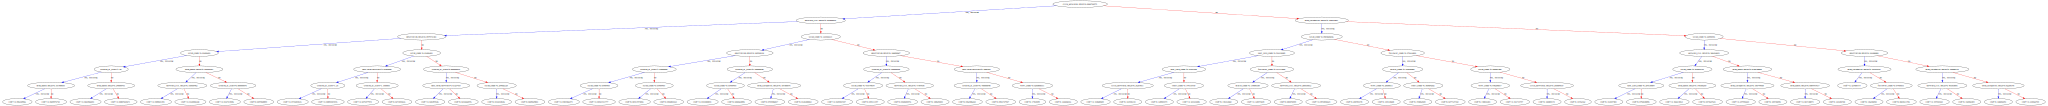

In [31]:
# xgb.plot_tree(ltr_model, num_trees=3)
xgb.to_graphviz(ltr_model, fmap=FEATURE_MAP_PATH, num_trees=3)

### Feature Importance
* Loss를 줄이는데 기여도가 가장 큰 순서대로

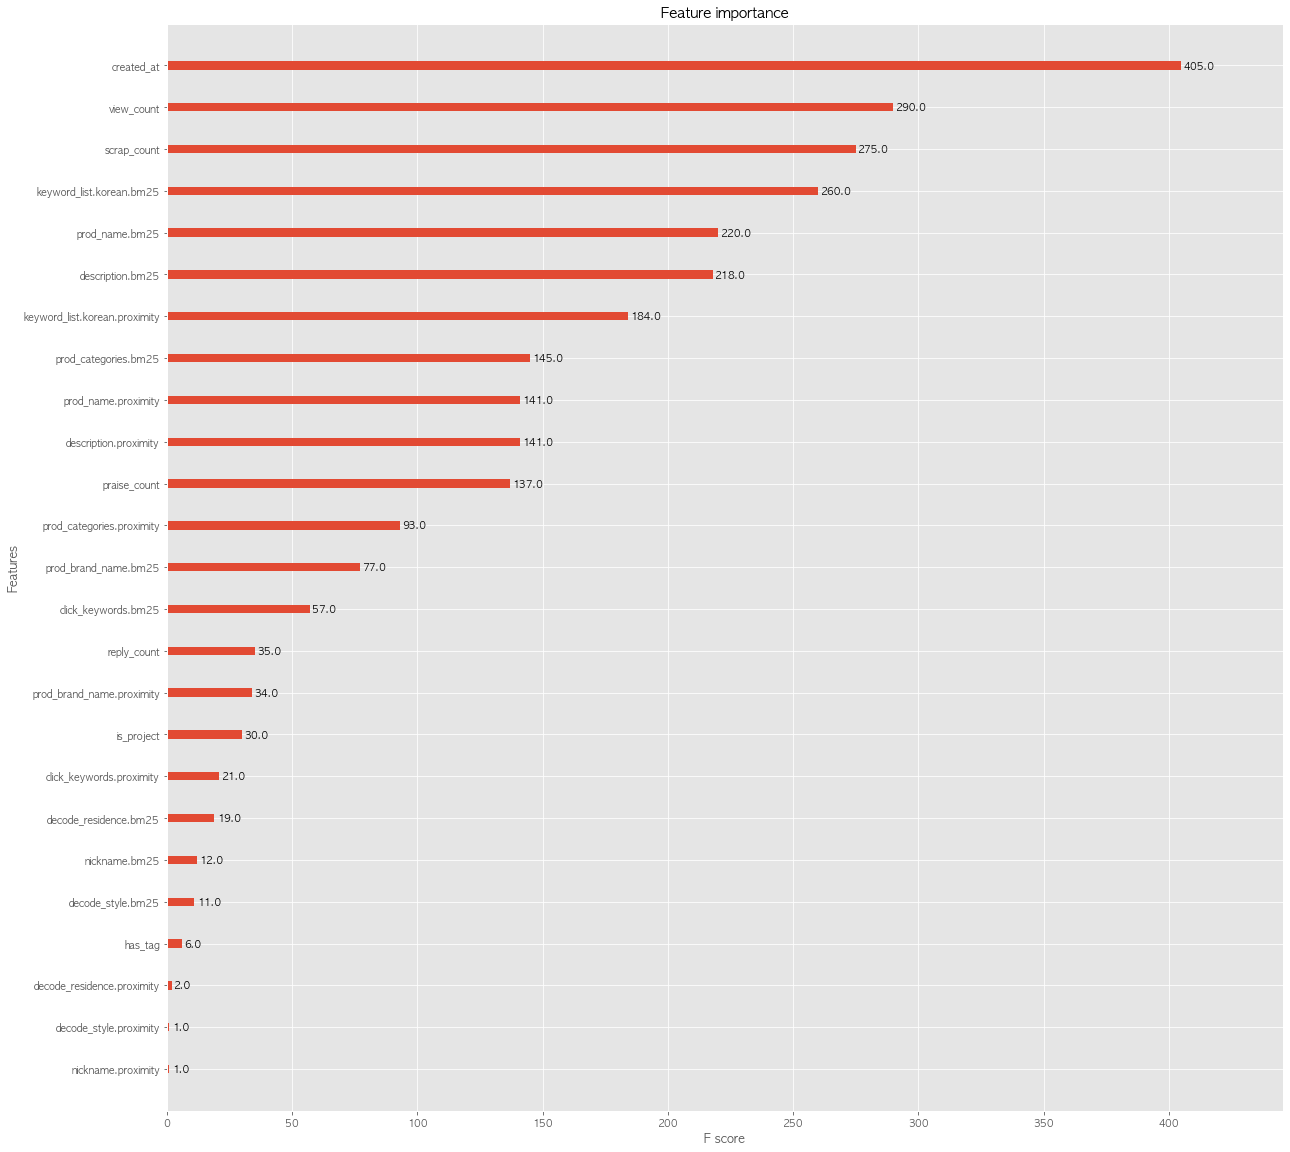

In [11]:
# this value is come frome `ltr_model.get_fscore()`
ax = xgb.plot_importance(ltr_model, fmap=FEATURE_MAP_PATH)
fig = ax.figure
fig.set_size_inches(20, 20)

### Uploading an XGBoost model to the plugin

Since the model can be represented with JSON, the plugin can parse it. But we need to make sure the plugin gets the proper feature value names in order for it to parse properly.

These are supplied via a mapping `txt` file, `fmap.txt`.

The first step is to dump the model with the feature mapping to the features already stored in the plugin.

In [13]:
FEATURESET = "card.featureset.v2"
INDEX = "ThisIsUnused"           # 사실상 사용되지는 않고 있음(피쳐셋 경로를 사용)
RANKING_MODEL = "lambdamart"
MODEL_NAME = f"xgb-{RANKING_MODEL}-{RANKING_DATA}.{FEATURESET}"
MODEL_NAME

'xgb-lambdamart-20220429.card.click.ranking.base.1w.features.grade.txt.card.featureset.v2'

In [14]:
import json
import ltr.client as client

client = client.ElasticClient()

model_dump = ltr_model.get_dump(fmap=FEATURE_MAP_PATH, dump_format='json')

# Manipulate the XGBoost output format to clean it up for posting to the plugin.
clean_model = [json.loads(line) for line in model_dump]

# Post it to the plugin
client.submit_xgboost_model(FEATURESET, INDEX, MODEL_NAME, clean_model)

URL Path: https://search-es2.stage.datahou.se/_ltr/_featureset/card.featureset.v2/_createmodel
Delete model xgb-lambdamart-20220429.card.click.ranking.base.1w.features.grade.txt.card.featureset.v2: 404
Created Model xgb-lambdamart-20220429.card.click.ranking.base.1w.features.grade.txt.card.featureset.v2 [Status: 201]


### Confirm it works

In [ ]:
from ltr.release_date_plot import search
search(client, 'batman', 'xgb')

/Users/junhyeok.kim/.pyenv/versions/3.9.6/envs/hello-ltr/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning:

Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.13/security-minimal-setup.html to enable security.



[{'id': '2661',
  'title': 'Batman',
  'overview': 'The Dynamic Duo faces four super-villains who plan to hold the world for ransom with the help of a secret invention that instantly dehydrates people.',
  'tagline': "He's Here Big As Life In A Real Bat-Epic",
  'directors': ['Leslie H. Martinson'],
  'cast': 'Adam West Burt Ward Lee Meriwether Cesar Romero Burgess Meredith Frank Gorshin Alan Napier Neil Hamilton Stafford Repp Madge Blake Reginald Denny Milton Frome Gil Perkins Dick Crockett George Sawaya Van Williams Jack LaLanne Arthur Tovey',
  'genres': ['Family', 'Adventure', 'Comedy', 'Science Fiction', 'Crime'],
  'release_date': '1966-07-30',
  'release_year': '1966',
  'poster_path': 'https://image.tmdb.org/t/p/w185/udDVJXtAFsQ8DimrXkVFqy4DGEQ.jpg',
  'vote_average': 6.0,
  'vote_count': 153,
  'score': 2.5180912},
 {'id': '93560',
  'title': 'Batman and Robin',
  'overview': 'This 15-chapter serial pits Batman and Robin against The Wizard, who uses a device that allows him to

### Compare it to the classic Ranklib model

In [ ]:
from ltr.release_date_plot import plot
plot(client, "batman", models = ['classic', 'xgb'])